#### **NEM Review contract co-design workshop**

# Contract financial performance modelling

## Prepare data

### Access generators from latest Generation Information

In [1]:
# Python libraries
import geopandas as gpd, matplotlib.pyplot as plt, matplotlib as mpl
import numpy as np, os, pandas as pd, seaborn as sns
from scripts.common_functions import python_setup, get_mms_data

# Set up Python
working_dir, charts_dir, data_dir = python_setup(2)

# Get generator details
sa_gen_info = pd.read_csv(
    os.path.join(data_dir, "sa_duids.csv"),
    index_col=0).dropna()

# Count DUIDs used in analysis
for tech in sa_gen_info["Technology"].value_counts().index:
    print(f"{tech}: {sa_gen_info["Technology"].value_counts().loc[tech]} generators")

Wind: 26 generators
Solar: 16 generators


### Collect historic DUID data for South Australia

If no data yet exists, execute SQL query to collect output, availability and maximum capacity data for each DUID.

In [2]:
# SA DUID data path
sa_duid_data_path = os.path.join(data_dir, "duid_data", "sa_duid_data.csv")

# Check if file exists
if not os.path.exists(sa_duid_data_path):
    print("sa_duid_data.csv not found. Querying database ...")

    # Define DUIDs of interest
    duid_list = sa_gen_info.index

    # Get generation and price data
    sa_duid_data = get_mms_data(
        script_name="collect_sa_duid_data",
        arguments={
            "start_date": "2020-01-01",
            "end_date": "2024-12-31",
            "duid_list": ",".join([f"'{d}'" for d in duid_list])})

    # Save data to file
    sa_duid_data.to_csv(sa_duid_data_path, index=False)    
    print(f"sa_duid_data saved.")

    # Save individual DUID files
    for duid in sa_duid_data["DUID"].unique():
        duid_data = sa_duid_data[
            sa_duid_data["DUID"] == duid].set_index("Interval").drop(columns="DUID")
        duid_data.to_csv(
            os.path.join(data_dir, "duid_data", f"{duid}_data.csv"))
    print("Individual DUID files saved.")

else:
    print(f"Loading existing sa_duid_data.csv file ...")
    # Load existing data
    sa_duid_data = pd.read_csv(
        sa_duid_data_path,
        parse_dates=[0])

# Display market data
print("Data loaded.")

Loading existing sa_duid_data.csv file ...
Data loaded.


### Collect whole-of-market data for South Australia

If no data yet exists, execute SQL query to collect SA prices and total demand data.

In [3]:
# SA demand and prices path
sa_demand_and_prices_path = os.path.join(data_dir, "sa_demand_and_prices.csv")

# Check if file exists
if not os.path.exists(sa_demand_and_prices_path):
    print("sa_demand_and_prices.csv not found. Querying database ...")

    # Get generation and price data
    sa_demand_and_prices = get_mms_data(
        script_name="collect_sa_demand_and_prices",
        arguments={
            "start_date": "2020-01-01",
            "end_date": "2024-12-31"})
    sa_demand_and_prices.set_index("Interval", inplace=True)

    # Save data to file
    sa_demand_and_prices.to_csv(sa_demand_and_prices_path)
    print(f"Data saved.")

else:
    print(f"Loading existing sa_demand_and_prices.csv file ...")
    # Load existing data
    sa_demand_and_prices = pd.read_csv(
        sa_demand_and_prices_path,
        parse_dates=[0],
        index_col=0)

# Display market data
print("Data loaded.")

Loading existing sa_demand_and_prices.csv file ...
Data loaded.


##  SA wind and solar market observations

Calculate and visualise metrics of:
* Size of the wind and solar fleets over time (2020 to 2024)
* Locations of generators
* Capacity factors of generators
* Seasonal shape of generation and load
* Intraday shape of generation and load
* Demand-weighted prices for SA, wind and solar

### Size of wind and solar fleets

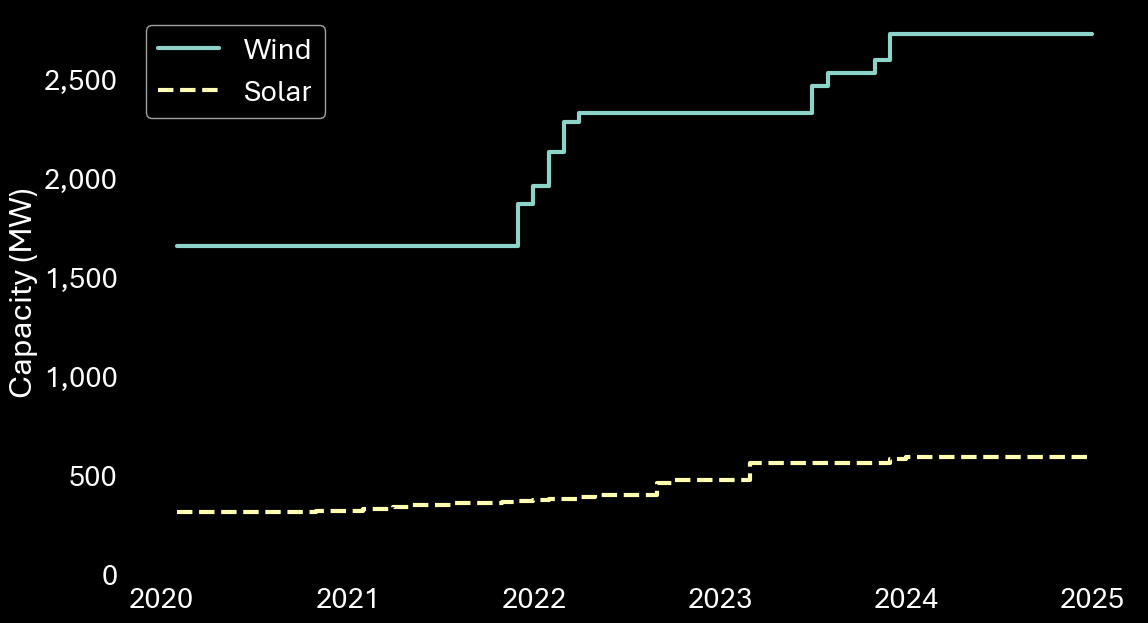

In [4]:
# Prepare data (aggregate to monthly)
# Attached 'technology' to DUID data
sa_duid_data["Technology"] = sa_gen_info.loc[
    sa_duid_data["DUID"],
    "Technology"].values

# Aggregate to monthly
chart_data = sa_duid_data.pivot_table(
    index="Interval",
    columns="Technology",
    values="Maximum capacity",
    aggfunc="sum").resample("ME").mean()

# Save data to file
chart_data.to_csv(
    os.path.join(data_dir, "growth_of_sa_fleet.csv"))

# Plot fleet sizes over time
fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True)
for i, tech in enumerate(["Wind", "Solar"]):
    ax.step(
        x=chart_data.index,
        y=chart_data[tech],
        where="pre",
        linewidth=3,
        color=f"C{i}",
        label=tech,
        linestyle=["-", "--"][i])
plt.xlabel(None)
plt.ylabel("Capacity (MW)")
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
plt.ylim(0)
plt.legend()
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
plt.savefig(
    os.path.join(charts_dir, "growth_of_sa_fleet.png"))
plt.show()

### Generator capacity factors

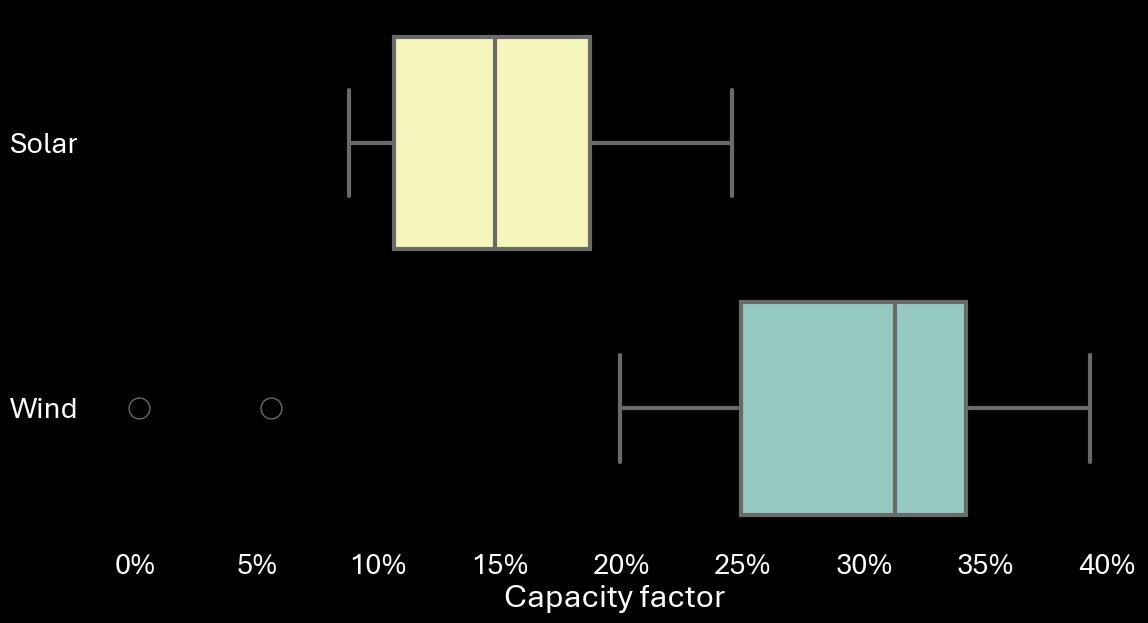

Aggregate fleet capacity factor:
Solar: 19.4%
Wind: 30.6%


In [5]:
# Calculate CFs
capacity_factors = sa_duid_data.pivot_table(
    index="DUID",
    columns="Technology",
    values="Relative output",
    aggfunc="mean").reset_index().melt(id_vars="DUID", var_name="Technology", value_name="Capacity factor").dropna()
# Save CFs
capacity_factors.to_csv(
    os.path.join(data_dir, "sa_capacity_factors.csv"),
    index=False)

# Plot CFs by technology
fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True)
sns.boxplot(
    data=capacity_factors,
    x="Capacity factor",
    y="Technology",
    hue="Technology",
    palette=["C1", "C0"],
    ax=ax,
    linewidth=3,
    fliersize=15)
ax.set_ylabel(None)
ax.xaxis.set_major_formatter(lambda x, p: f"{x:.0%}")
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
plt.savefig(
    os.path.join(charts_dir, "sa_fleet_capacity_factors.png"))
plt.show()

# Calculate aggregate CF
fleet_cf = sa_duid_data.pivot_table(
    index="Technology",
    values=["Output", "Maximum capacity"],
    aggfunc="sum")
fleet_cf["Capacity factor"] = fleet_cf["Output"] / fleet_cf["Maximum capacity"]
print("Aggregate fleet capacity factor:")
for tech in fleet_cf.index:
    print(f"{tech}: {fleet_cf.at[tech, 'Capacity factor']:.1%}")

### Generator locations

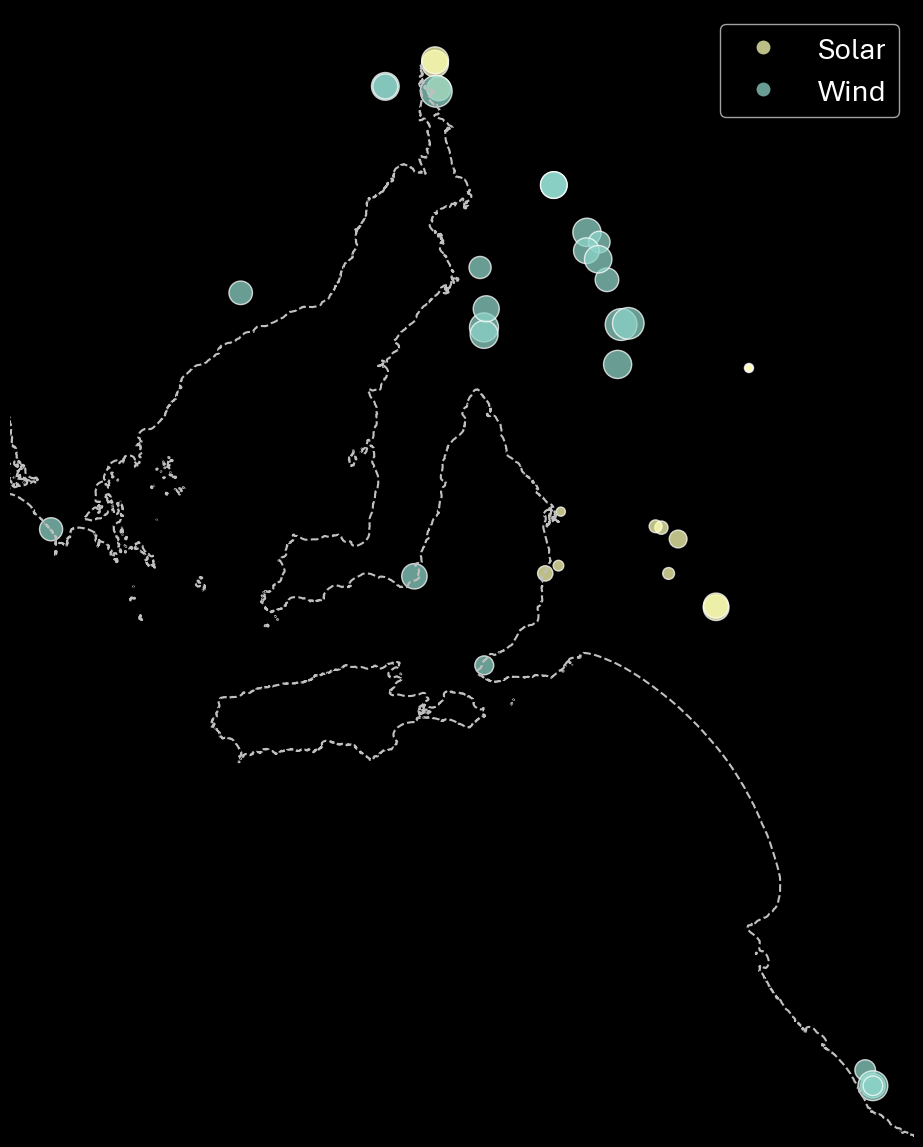

In [6]:
# Convert DUIDs to GeoDataFrame
sa_gen_geo = gpd.GeoDataFrame(
    sa_gen_info,
    geometry=gpd.points_from_xy(
        sa_gen_info.Longitude,
        sa_gen_info.Latitude,
        crs="3857"))

# Load states shapefile
states = gpd.read_file(
    os.path.join(data_dir, "australian_states_map.zip"))

# Plot states outline
marker_sizes = np.sqrt(sa_gen_geo["Maximum capacity"] / np.pi)
fig, ax = plt.subplots(
    figsize=(12, 12),
    tight_layout=True)
sa_gen_geo.plot(
    "Technology",
    cmap=mpl.colors.ListedColormap(["C1", "C0"]),
    markersize=(
        (np.sqrt(sa_gen_geo["Maximum capacity"] / np.pi) - marker_sizes.min()) / 
        (marker_sizes.max() - marker_sizes.min()) * 500 + 25),
    alpha=.75,
    edgecolor="white",
    ax=ax,
    legend=True)
limits = ax.get_xlim(), ax.get_ylim()
states.boundary.plot(
    color="silver",
    linestyle="--",
    ax=ax)
plt.xlim(limits[0][0], limits[0][1])
plt.ylim(limits[1][0], limits[1][1])
ax.set_axis_off()
plt.savefig(
    os.path.join(charts_dir, "sa_generator_locations.png"))
plt.show()

### Seasonal shape of generation and load

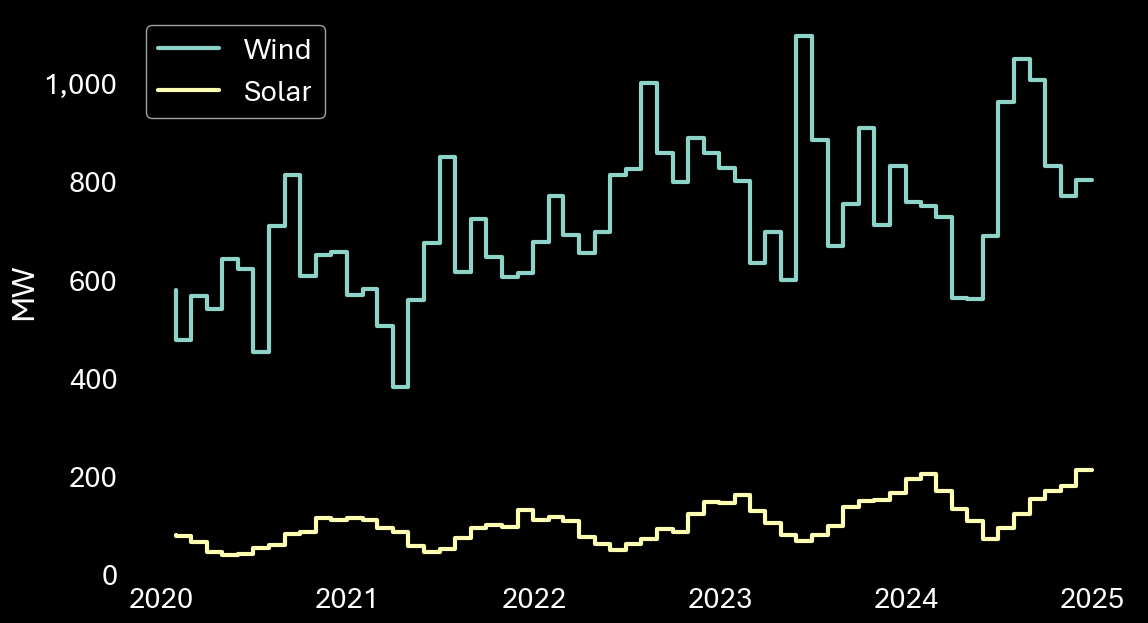

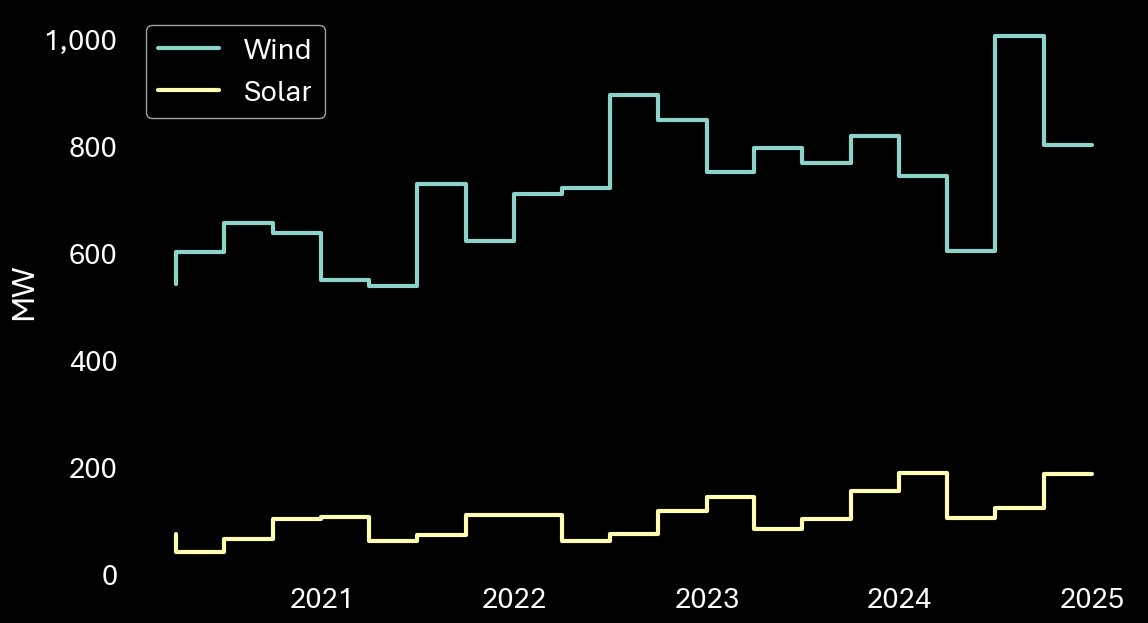

In [7]:
# Monthly and quarterly generation data
gen_data = sa_duid_data.pivot_table(
    index="Interval",
    columns="Technology",
    values="Availability",
    aggfunc="sum")
gen_mth = gen_data.resample("ME").mean()
gen_mth.index.name = "Month"
gen_qtr = gen_data.resample("QE").mean()
gen_qtr.index.name = "Quarter"
# Save generation data
gen_mth.to_csv(
    os.path.join(data_dir, "sa_monthly_generation.csv"))
gen_qtr.to_csv(
    os.path.join(data_dir, "sa_quarterly_generation.csv"))

# Plot generation
fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True)
for i, tech in enumerate(["Wind", "Solar"]):
    ax.step(
        x=gen_mth.index,
        y=gen_mth[tech],
        where="pre",
        linewidth=3,
        color=f"C{i}",
        label=tech)
plt.ylabel("MW")
plt.ylim(0)
plt.legend()
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
plt.savefig(
    os.path.join(charts_dir, "sa_mean_monthly_generation.png"))
plt.show()

fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True)
for i, tech in enumerate(["Wind", "Solar"]):
    ax.step(
        x=gen_qtr.index,
        y=gen_qtr[tech],
        where="pre",
        linewidth=3,
        color=f"C{i}",
        label=tech)
plt.ylabel("MW")
plt.ylim(0)
plt.legend()
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
plt.savefig(
    os.path.join(charts_dir, "sa_mean_quarterly_generation.png"))
plt.show()

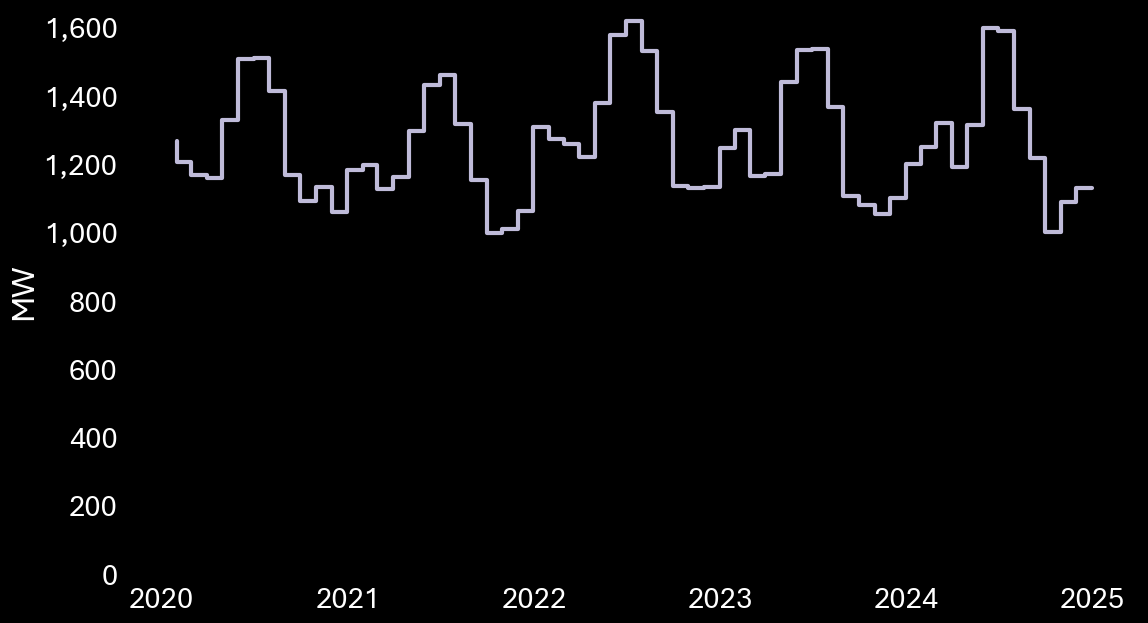

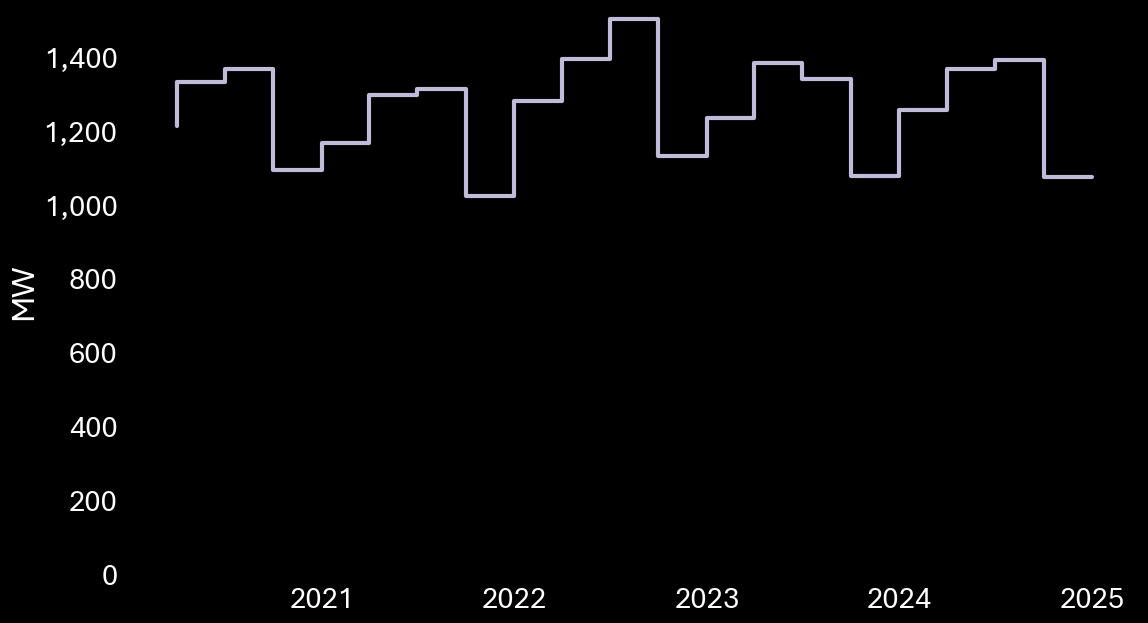

In [8]:
# Monthly and quarterly load data
load_mth = sa_demand_and_prices.resample("ME")["Total demand"].mean()
load_mth.index.name = "Month"
load_qtr = sa_demand_and_prices.resample("QE")["Total demand"].mean()
load_qtr.index.name = "Quarter"
# Save load data
load_mth.to_csv(
    os.path.join(data_dir, "sa_monthly_load.csv"))
load_qtr.to_csv(
    os.path.join(data_dir, "sa_quarterly_load.csv"))

# Plot load
fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True)
ax.step(
    x=load_mth.index,
    y=load_mth,
    where="pre",
    linewidth=3,
    color="C2")
plt.ylabel("MW")
plt.ylim(0)
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
plt.savefig(
    os.path.join(charts_dir, "sa_mean_monthly_load.png"))
plt.show()

fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True)
ax.step(
    x=load_qtr.index,
    y=load_qtr,
    where="pre",
    linewidth=3,
    color="C2")
plt.ylabel("MW")
plt.ylim(0)
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
plt.savefig(
    os.path.join(charts_dir, "sa_mean_quarterly_load.png"))
plt.show()

### Intraday shape of generation and load

<function matplotlib.pyplot.show(close=None, block=None)>

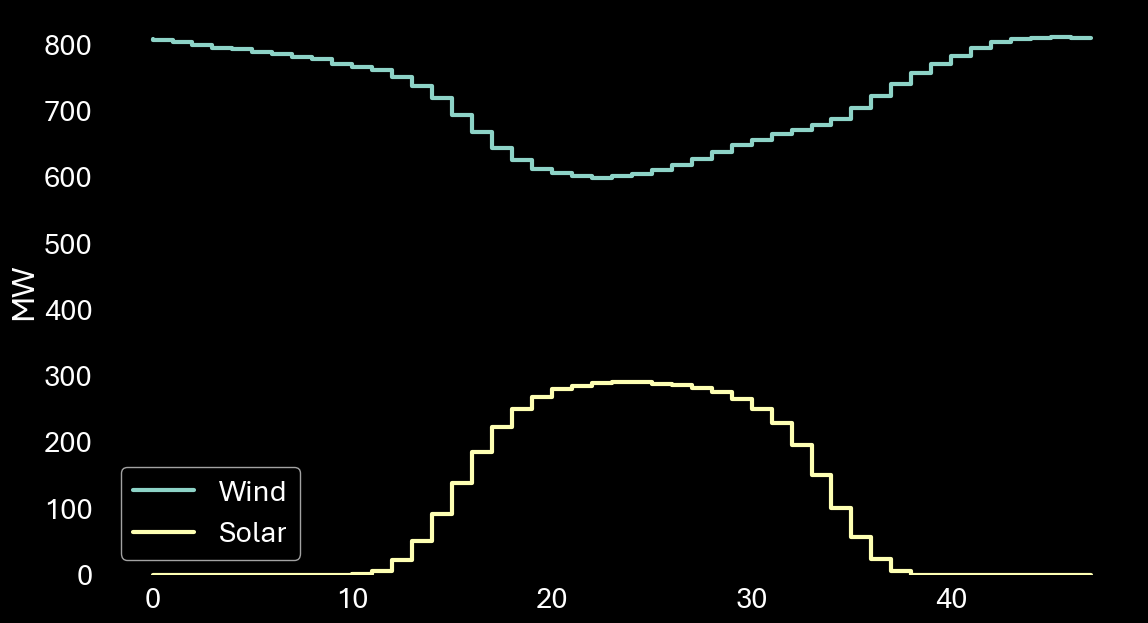

In [9]:
# Prepare generation data
sa_intraday_gen_data = sa_duid_data.pivot_table(
    index="Interval",
    columns="Technology",
    values="Availability",
    aggfunc="sum")
sa_intraday_gen_data["30-min interval"] = sa_intraday_gen_data.index.hour * 2 + sa_intraday_gen_data.index.minute // 30
chart_data = sa_intraday_gen_data.pivot_table(
    index="30-min interval",
    values=["Wind", "Solar"],
    aggfunc="mean")

# Save intraday generation data
chart_data.to_csv(
    os.path.join(data_dir, "sa_mean_intraday_generation.csv"))

# Plot intraday generation
fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True)
for i, tech in enumerate(["Wind", "Solar"]):
    ax.step(
        x=chart_data.index,
        y=chart_data[tech],
        where="pre",
        linewidth=3,
        color=f"C{i}",
        label=tech)
plt.ylabel("MW")
plt.ylim(0)
plt.legend()
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
plt.savefig(
    os.path.join(charts_dir, "sa_mean_intraday_generation.png"))
plt.show

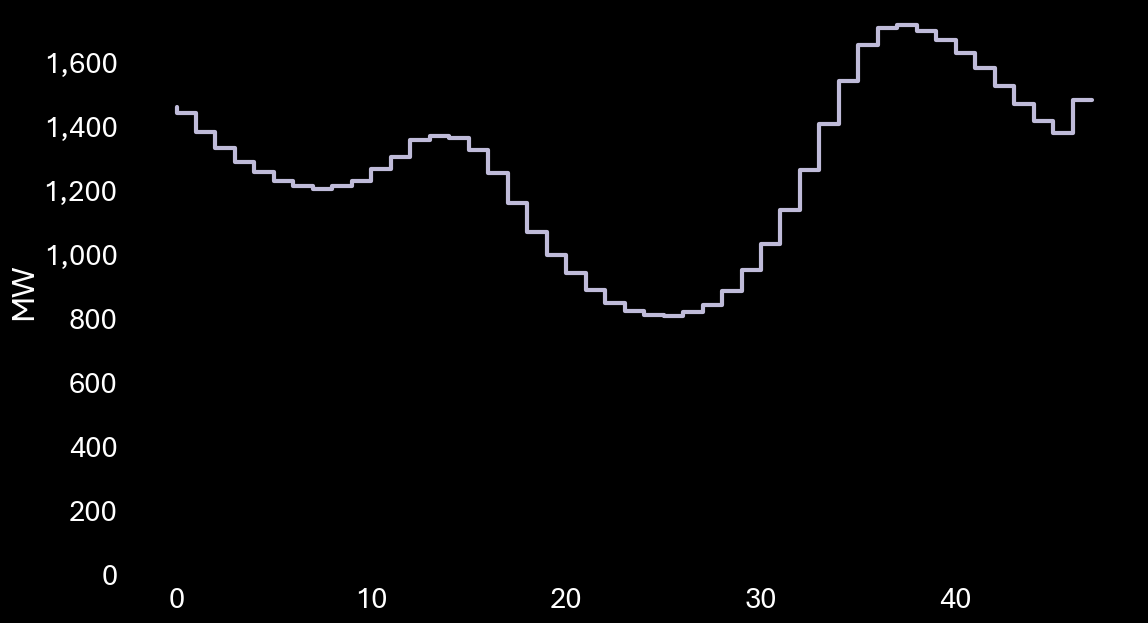

In [10]:
# Prepare load data
sa_demand_and_prices["30-min interval"] = sa_demand_and_prices.index.hour * 2 + sa_intraday_gen_data.index.minute // 30
chart_data = sa_demand_and_prices.pivot_table(
    index="30-min interval",
    values="Total demand",
    aggfunc="mean")

# Save intraday generation data
chart_data.to_csv(
    os.path.join(data_dir, "sa_mean_intraday_load.csv"))

# Plot intraday generation
fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True)
ax.step(
    x=chart_data.index,
    y=chart_data["Total demand"],
    where="pre",
    linewidth=3,
    color="C2")
plt.ylabel("MW")
plt.ylim(0)
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
plt.savefig(
    os.path.join(charts_dir, "sa_mean_intraday_load.png"))
plt.show()

### Demand-weighted prices: SA market, wind and solar


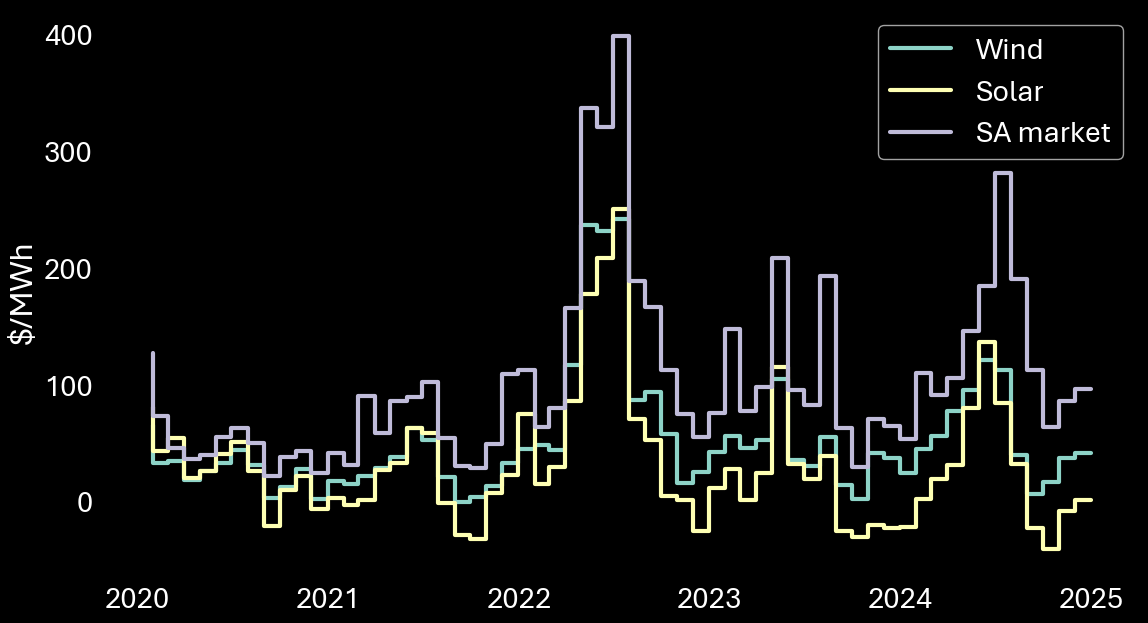

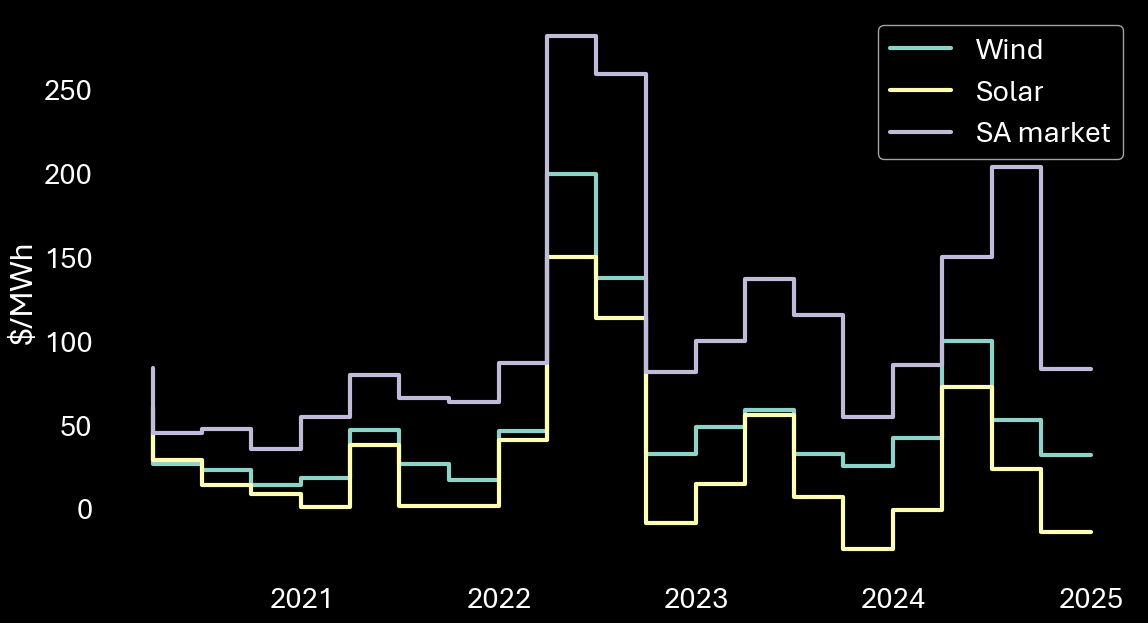

In [11]:
# Prepare volume-weighted price data
sa_demand_and_prices["Total value"] = sa_demand_and_prices["Total demand"] * sa_demand_and_prices["Price"]

# Merge price and generation data
sa_gen_prices = sa_duid_data.pivot_table(
    index="Interval",
    columns="Technology",
    values="Availability",
    aggfunc="sum")
sa_gen_prices["Price"] = sa_demand_and_prices.loc[
    sa_gen_prices.index, "Price"]
sa_gen_prices["Solar total value"] = sa_gen_prices["Solar"] * sa_gen_prices["Price"]
sa_gen_prices["Wind total value"] = sa_gen_prices["Wind"] * sa_gen_prices["Price"]

# Calculate monthly prices
dwa_prices_sa_mth = sa_demand_and_prices.resample("ME")[["Total demand", "Total value"]].sum()
dwa_prices_sa_solar_mth = sa_gen_prices.resample("ME")[["Solar", "Solar total value"]].sum()
dwa_prices_sa_wind_mth = sa_gen_prices.resample("ME")[["Wind", "Wind total value"]].sum()
dwa_prices_sa_mth["DWA price"] = dwa_prices_sa_mth["Total value"] / dwa_prices_sa_mth["Total demand"]
dwa_prices_sa_solar_mth["DWA price"] = dwa_prices_sa_solar_mth["Solar total value"] / dwa_prices_sa_solar_mth["Solar"]
dwa_prices_sa_wind_mth["DWA price"] = dwa_prices_sa_wind_mth["Wind total value"] / dwa_prices_sa_wind_mth["Wind"]
# Calculate quarterly prices
dwa_prices_sa_qtr = sa_demand_and_prices.resample("QE")[["Total demand", "Total value"]].sum()
dwa_prices_sa_solar_qtr = sa_gen_prices.resample("QE")[["Solar", "Solar total value"]].sum()
dwa_prices_sa_wind_qtr = sa_gen_prices.resample("QE")[["Wind", "Wind total value"]].sum()
dwa_prices_sa_qtr["DWA price"] = dwa_prices_sa_qtr["Total value"] / dwa_prices_sa_qtr["Total demand"]
dwa_prices_sa_solar_qtr["DWA price"] = dwa_prices_sa_solar_qtr["Solar total value"] / dwa_prices_sa_solar_qtr["Solar"]
dwa_prices_sa_wind_qtr["DWA price"] = dwa_prices_sa_wind_qtr["Wind total value"] / dwa_prices_sa_wind_qtr["Wind"]
# Save to file
dwa_prices_sa_mth.iloc[:, -1:].to_csv(
    os.path.join(data_dir, "sa_dwa_prices_monthly.csv"))
dwa_prices_sa_solar_mth.iloc[:, -1:].to_csv(
    os.path.join(data_dir, "sa_dwa_solar_prices_monthly.csv"))
dwa_prices_sa_wind_mth.iloc[:, -1:].to_csv(
    os.path.join(data_dir, "sa_dwa_wind_prices_monthly.csv"))
dwa_prices_sa_qtr.iloc[:, -1:].to_csv(
    os.path.join(data_dir, "sa_dwa_prices_quarterly.csv"))
dwa_prices_sa_solar_qtr.iloc[:, -1:].to_csv(
    os.path.join(data_dir, "sa_dwa_solar_prices_quarterly.csv"))
dwa_prices_sa_wind_qtr.iloc[:, -1:].to_csv(
    os.path.join(data_dir, "sa_dwa_wind_prices_quarterly.csv"))

# Plot load
fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True)
ax.step(
    x=dwa_prices_sa_wind_mth.index,
    y=dwa_prices_sa_wind_mth["DWA price"],
    where="pre",
    linewidth=3,
    color="C0",
    label="Wind")
ax.step(
    x=dwa_prices_sa_solar_mth.index,
    y=dwa_prices_sa_solar_mth["DWA price"],
    where="pre",
    linewidth=3,
    color="C1",
    label="Solar")
ax.step(
    x=dwa_prices_sa_mth.index,
    y=dwa_prices_sa_mth["DWA price"],
    where="pre",
    linewidth=3,
    color="C2",
    label="SA market")
plt.ylabel("$/MWh")
plt.legend()
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
plt.savefig(
    os.path.join(charts_dir, "dwa_prices_sa_monthly.png"))
plt.show()

# Plot load
fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True)
ax.step(
    x=dwa_prices_sa_wind_qtr.index,
    y=dwa_prices_sa_wind_qtr["DWA price"],
    where="pre",
    linewidth=3,
    color="C0",
    label="Wind")
ax.step(
    x=dwa_prices_sa_solar_qtr.index,
    y=dwa_prices_sa_solar_qtr["DWA price"],
    where="pre",
    linewidth=3,
    color="C1",
    label="Solar")
ax.step(
    x=dwa_prices_sa_qtr.index,
    y=dwa_prices_sa_qtr["DWA price"],
    where="pre",
    linewidth=3,
    color="C2",
    label="SA market")
plt.ylabel("$/MWh")
plt.legend()
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
plt.savefig(
    os.path.join(charts_dir, "dwa_prices_sa_quarterly.png"))
plt.show()